In [6]:
#from shapely import wkt
#import networkx as nx
import pandas as pd
import numpy as np
import math
import sys
import os

import matplotlib.pyplot as plt
#import geopandas as gpd

# Local imports
from global_config import config

data_dir    = config.get_property('covid_fb')

# Reads the parameters from excecution
location_name        =  'bogota'   # sys.argv[1] # location name # bogota
agglomeration_folder =  'geometry' # sys.argv[2] # agglomeration name #

polygonspop_path = os.path.join(data_dir, "agglomerated", agglomeration_folder, "polygons_pop.csv")
movement_path = os.path.join(data_dir,    "agglomerated", agglomeration_folder, "movement.csv")
polygons_path = os.path.join(data_dir,    "agglomerated", agglomeration_folder, "polygons.csv")
cases_path    = os.path.join(data_dir,    "agglomerated", agglomeration_folder, "cases.csv")


dict_correct = {'Los Martires': 'Los Mártires', 'Fontibon': 'Fontibón', 'Engativa': 'Engativá',
                            'San Cristobal': 'San Cristóbal', 'Usaquen': 'Usaquén',
                            'Ciudad Bolivar': 'Ciudad Bolívar', 'Candelaria': 'La Candelaria'}



In [7]:
# Load Polygons
df_polygons = pd.read_csv(polygons_path)
df_polygons_pop = pd.read_csv(polygonspop_path).set_index('poly_id')
df_polygons["deaths_per10000"] = df_polygons.apply(lambda x: x["num_diseased"] * 10000 / df_polygons_pop.loc[x.poly_id]["population"], axis=1)
#df_polygons = df_polygons.sort_values(by='deaths_per10000') # num_diseased
df_polygons = df_polygons.sort_values(by='num_diseased') # num_diseased
df_polygons["poly_name"] = df_polygons["poly_id"].map(lambda x: ' '.join([w.capitalize() for w in x.replace('colombia_bogota_localidad_', '').split('_')])).replace(dict_correct)

# Load cases
df_cases = pd.read_csv(cases_path, parse_dates=["date_time"])
df_cases = df_cases.groupby(['poly_id', 'date_time'] ).sum().unstack([0]).resample('W-Sun').agg('sum').stack()[["num_cases", "num_diseased"]].reset_index().set_index('date_time')
df_cases["poly_name"] = df_cases["poly_id"].map(lambda x: ' '.join([w.capitalize() for w in x.replace('colombia_bogota_localidad_', '').split('_')])).replace(dict_correct)
df_cases = df_cases[["poly_id", "poly_name", "num_cases", "num_diseased"]]
df_cases["cases_per10000"]  = df_cases.apply(lambda x: x["num_cases"] * 10000 / df_polygons_pop.loc[x.poly_id]["population"], axis=1)
df_cases["deaths_per10000"] = df_cases.apply(lambda x: x["num_diseased"] * 10000 / df_polygons_pop.loc[x.poly_id]["population"], axis=1)

df_cases_hm = pd.pivot(df_cases.reset_index(), index='poly_name', columns='date_time', values='cases_per10000');   df_cases_hm = df_cases_hm.loc[df_polygons.poly_name]
df_deaths_hm = pd.pivot(df_cases.reset_index(), index='poly_name', columns='date_time', values='deaths_per10000'); df_deaths_hm = df_deaths_hm.loc[df_polygons.poly_name]



In [16]:

data_col_path = '/Users/chaosdonkey06/Dropbox/covid_fb/data/data_stages/colombia'
movement_path = os.path.join(data_col_path,    "agglomerated", agglomeration_folder, "movement.csv")
polygons_path = os.path.join(data_col_path,    "agglomerated", agglomeration_folder, "polygons.csv")
cases_path    = os.path.join(data_col_path,    "agglomerated", agglomeration_folder, "cases.csv")

df_polygons = pd.read_csv(polygons_path)
df_polygons["deaths_per10000"] = df_polygons.apply(lambda x: x["num_diseased"] * 10000 /x["attr_population"], axis=1)

## Change this to sort by 10000 individuals ##
#df_polygons = df_polygons.sort_values(by='deaths_per10000')
df_polygons = df_polygons.sort_values(by='num_diseased') # num_diseased

df_polygons = df_polygons.set_index('poly_id')

# Load cases
df_cases = pd.read_csv(cases_path, parse_dates=["date_time"])
df_cases["poly_name"] = df_cases["location"]
df_cases = df_cases.groupby(['poly_id', 'poly_name', 'date_time'] ).sum().unstack([0,1]).resample('W-Sun').agg('sum').stack().stack()[["num_cases", "num_diseased"]].reset_index().set_index('date_time')


In [17]:

df_cases = df_cases[["poly_id", "poly_name", "num_cases", "num_diseased"]]
df_cases["cases_per10000"]  = df_cases.apply(lambda x: x["num_cases"] * 10000 / df_polygons.loc[x.poly_id]["attr_population"], axis=1)
df_cases["deaths_per10000"] = df_cases.apply(lambda x: x["num_diseased"] * 10000 / df_polygons.loc[x.poly_id]["attr_population"], axis=1)

df_cases_hm  = pd.pivot( df_cases.reset_index(), index='poly_name', columns='date_time', values='cases_per10000');  df_cases_hm = df_cases_hm.loc[df_polygons.poly_name]
df_deaths_hm = pd.pivot( df_cases.reset_index(), index='poly_name', columns='date_time', values='deaths_per10000'); df_deaths_hm = df_deaths_hm.loc[df_polygons.poly_name]

df_cases_hm


date_time,2020-03-08,2020-03-15,2020-03-22,2020-03-29,2020-04-05,2020-04-12,2020-04-19,2020-04-26,2020-05-03,2020-05-10,...,2021-03-14,2021-03-21,2021-03-28,2021-04-04,2021-04-11,2021-04-18,2021-04-25,2021-05-02,2021-05-09,2021-05-16
poly_name,,,,,,,,,,,,,,,,,,,,,
Montebello-Antioquia,0.000000,0.000000,0.000000,1.716738,3.433476,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.716738,1.716738,10.300429,12.017167,15.450644,17.167382,22.317597,10.300429,6.866953
Macaravita-Santander,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Jordán-Santander,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,91.827365
Confines-Santander,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,3.710575,3.710575,3.710575,0.000000,0.000000,0.000000
Sipí-Chocó,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.370230,2.370230,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cúcuta-Norte de Santander,0.000000,0.014948,0.089691,0.089691,0.119588,0.239175,0.224227,0.029897,0.224227,0.119588,...,1.704122,2.361854,3.109276,2.705668,6.681954,6.786593,7.608757,6.308243,8.849478,9.118550
Barranquilla-Atlántico,0.000000,0.000000,0.056783,0.105454,0.194684,0.227132,0.089230,0.316362,1.046427,1.541250,...,23.589229,44.128407,73.136345,99.378146,134.072484,105.818947,93.829648,69.834827,40.405073,26.533827
Cali-Valle del Cauca,0.000000,0.004090,0.073611,0.179938,0.335340,0.993751,0.413040,0.707485,0.719754,0.932408,...,7.545145,9.217755,11.258420,15.417451,22.173321,25.326333,23.498322,14.002481,12.039516,9.692138


In [39]:

from matplotlib.dates import date2num, num2date
from matplotlib.colors import ListedColormap
from matplotlib import dates as mdates
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
from matplotlib import ticker



<ipython-input-40-e14fae09cee1>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels([df_cases_hm_plot.keys()[min(int(i), len(df_cases_hm_plot.keys())-1) ].strftime('%b-%y') for i in xt])
<ipython-input-40-e14fae09cee1>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels([df_deaths_hm_plot.keys()[min(int(i), len(df_deaths_hm_plot.keys())-1) ].strftime('%b-%y') for i in xt])


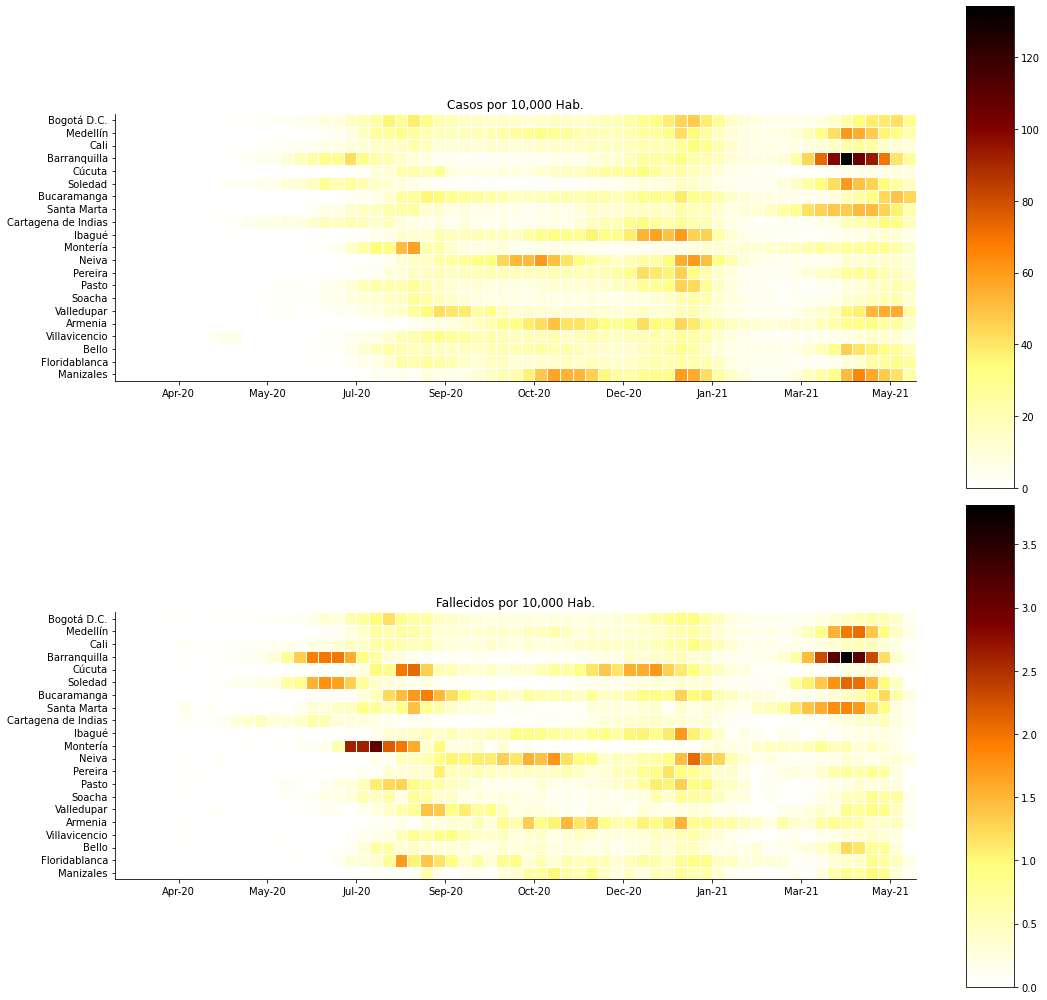

In [40]:

df_cases_hm_plot  = df_cases_hm.iloc[-21:].copy()
df_deaths_hm_plot = df_deaths_hm.iloc[-21:].copy()

df_cases_hm_plot.index  = [w.split('-')[0] for w in df_cases_hm_plot.index.values]
df_deaths_hm_plot.index = [w.split('-')[0] for w in df_deaths_hm_plot.index.values]


fig, axes = plt.subplots(2, 1, figsize=(15.7, 14))
im1 = axes[0].pcolormesh(df_cases_hm_plot, cmap='afmhot_r',  edgecolor='w', shading='auto')
fig.colorbar(im1, ax=axes[0],  aspect=10)

im2 = axes[1].pcolormesh(df_deaths_hm_plot, cmap='afmhot_r',  edgecolor='w', shading='auto')
fig.colorbar(im2, ax=axes[1],  aspect=10)

axes[0].set_title('Casos por 10,000 Hab.')
axes[1].set_title('Fallecidos por 10,000 Hab.')


axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[0].set_aspect('equal')
axes[1].set_aspect('equal')

#axes[0].xaxis.set_major_locator(mdates.MonthLocator())
##axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
axes[0].xaxis.set_minor_locator(mdates.WeekdayLocator())
axes[0].xaxis.set_major_locator(mdates.WeekdayLocator())

#axes[1].xaxis.set_major_locator(mdates.MonthLocator())
##axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
axes[1].xaxis.set_minor_locator(mdates.WeekdayLocator())
axes[1].xaxis.set_major_locator(mdates.WeekdayLocator())

df_cases_hm_plot

xt = axes[1].get_xticks()
axes[0].set_xticklabels([df_cases_hm_plot.keys()[min(int(i), len(df_cases_hm_plot.keys())-1) ].strftime('%b-%y') for i in xt])
axes[1].set_xticklabels([df_deaths_hm_plot.keys()[min(int(i), len(df_deaths_hm_plot.keys())-1) ].strftime('%b-%y') for i in xt])

axes[0].set_yticks([len(df_cases_hm_plot.index.values)-1 - idx + 0.5 for idx, loc in enumerate(df_cases_hm_plot.index.values)])
axes[0].set_yticklabels([loc for loc in df_cases_hm_plot.index.values[::-1]], rotation='horizontal', va='center')

axes[1].set_yticks( [len(df_cases_hm_plot.index.values)-1 - idx + 0.5 for idx, loc in enumerate(df_cases_hm_plot.index.values)] )
axes[1].set_yticklabels([loc for loc in df_cases_hm_plot.index.values[::-1]], rotation='horizontal', va='center')
plt.tight_layout()
fig.savefig( os.path.join('/Users/chaosdonkey06/Dropbox/My Mac (Jaimes-MacBook-Pro.local)/Desktop', 'cases_deaths_hm_top20.png'), dpi=300, transparent=True)



<ipython-input-43-b0086f620ff8>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels([df_cases_hm_plot.keys()[min(int(i), len(df_cases_hm_plot.keys())-1) ].strftime('%b-%y') for i in xt])
<ipython-input-43-b0086f620ff8>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels([df_deaths_hm_plot.keys()[min(int(i), len(df_deaths_hm_plot.keys())-1) ].strftime('%b-%y') for i in xt])


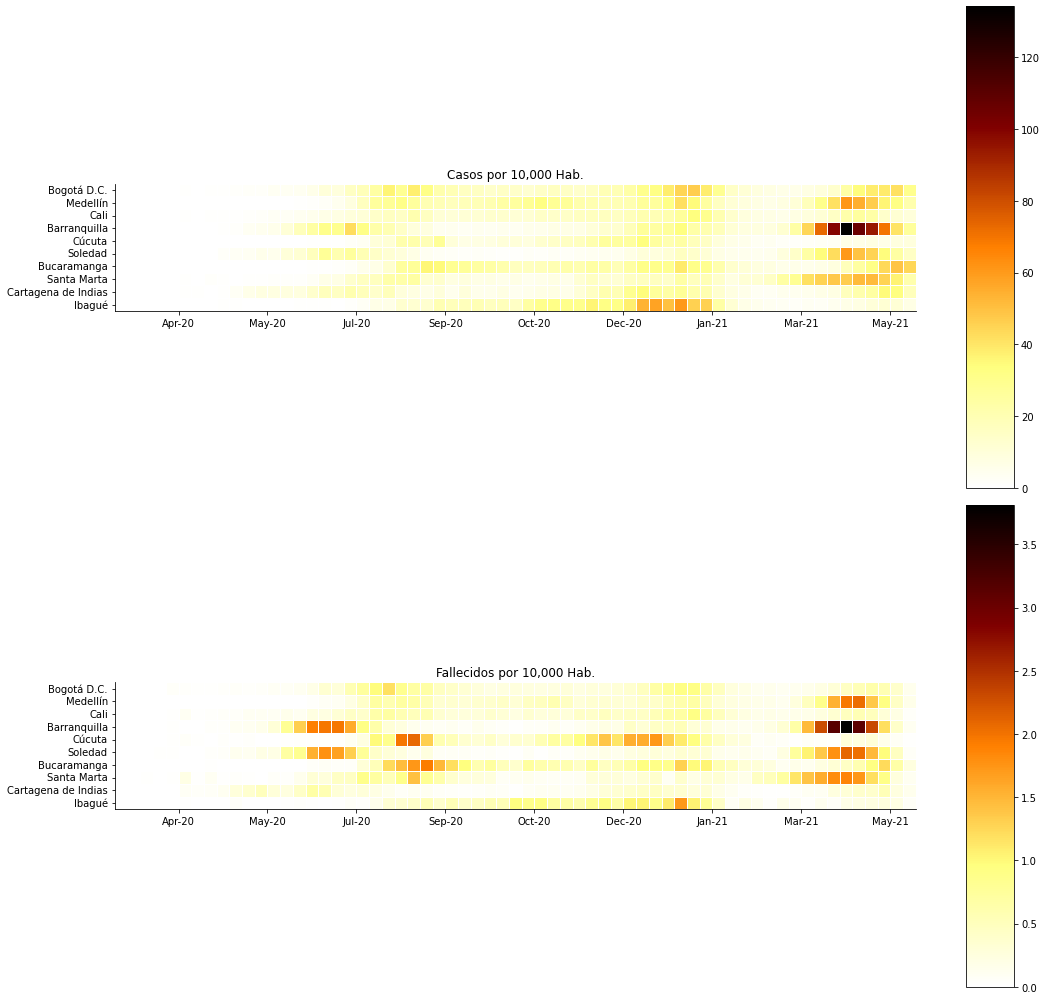

In [43]:



df_cases_hm_plot  = df_cases_hm.iloc[-10:].copy()
df_deaths_hm_plot = df_deaths_hm.iloc[-10:].copy()

df_cases_hm_plot.index  = [w.split('-')[0] for w in df_cases_hm_plot.index.values]
df_deaths_hm_plot.index = [w.split('-')[0] for w in df_deaths_hm_plot.index.values]


fig, axes = plt.subplots(2, 1, figsize=(15.7, 14))
im1 = axes[0].pcolormesh(df_cases_hm_plot, cmap='afmhot_r',  edgecolor='w', shading='auto')
fig.colorbar(im1, ax=axes[0],  aspect=10)

im2 = axes[1].pcolormesh(df_deaths_hm_plot, cmap='afmhot_r',  edgecolor='w', shading='auto')
fig.colorbar(im2, ax=axes[1],  aspect=10)

axes[0].set_title('Casos por 10,000 Hab.')
axes[1].set_title('Fallecidos por 10,000 Hab.')


axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[0].set_aspect('equal')
axes[1].set_aspect('equal')

#axes[0].xaxis.set_major_locator(mdates.MonthLocator())
##axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
axes[0].xaxis.set_minor_locator(mdates.WeekdayLocator())
axes[0].xaxis.set_major_locator(mdates.WeekdayLocator())

#axes[1].xaxis.set_major_locator(mdates.MonthLocator())
##axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
axes[1].xaxis.set_minor_locator(mdates.WeekdayLocator())
axes[1].xaxis.set_major_locator(mdates.WeekdayLocator())

df_cases_hm_plot

xt = axes[1].get_xticks()
axes[0].set_xticklabels([df_cases_hm_plot.keys()[min(int(i), len(df_cases_hm_plot.keys())-1) ].strftime('%b-%y') for i in xt])
axes[1].set_xticklabels([df_deaths_hm_plot.keys()[min(int(i), len(df_deaths_hm_plot.keys())-1) ].strftime('%b-%y') for i in xt])

axes[0].set_yticks([len(df_cases_hm_plot.index.values)-1 - idx + 0.5 for idx, loc in enumerate(df_cases_hm_plot.index.values)])
axes[0].set_yticklabels([loc for loc in df_cases_hm_plot.index.values[::-1]], rotation='horizontal', va='center')

axes[1].set_yticks( [len(df_cases_hm_plot.index.values)-1 - idx + 0.5 for idx, loc in enumerate(df_cases_hm_plot.index.values)] )
axes[1].set_yticklabels([loc for loc in df_cases_hm_plot.index.values[::-1]], rotation='horizontal', va='center')
plt.tight_layout()
fig.savefig( os.path.join('/Users/chaosdonkey06/Dropbox/My Mac (Jaimes-MacBook-Pro.local)/Desktop', 'cases_deaths_hm_top5.png'), dpi=300, transparent=True)




In [45]:



df_cases_hm_plot  = df_cases_hm.iloc[-41:].copy()
df_deaths_hm_plot = df_deaths_hm.iloc[-41:].copy()

df_cases_hm_plot.index  = [w.split('-')[0] for w in df_cases_hm_plot.index.values]
df_deaths_hm_plot.index = [w.split('-')[0] for w in df_deaths_hm_plot.index.values]


fig, axes = plt.subplots(2, 1, figsize=(15.7, 14))
im1 = axes[0].pcolormesh(df_cases_hm_plot, cmap='afmhot_r',  edgecolor='w', shading='auto')
fig.colorbar(im1, ax=axes[0],  aspect=10)

im2 = axes[1].pcolormesh(df_deaths_hm_plot, cmap='afmhot_r',  edgecolor='w', shading='auto')
fig.colorbar(im2, ax=axes[1],  aspect=10)

axes[0].set_title('Casos por 10,000 Hab.')
axes[1].set_title('Fallecidos por 10,000 Hab.')


axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[0].set_aspect('equal')
axes[1].set_aspect('equal')

#axes[0].xaxis.set_major_locator(mdates.MonthLocator())
##axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
axes[0].xaxis.set_minor_locator(mdates.WeekdayLocator())
axes[0].xaxis.set_major_locator(mdates.WeekdayLocator())

#axes[1].xaxis.set_major_locator(mdates.MonthLocator())
##axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
axes[1].xaxis.set_minor_locator(mdates.WeekdayLocator())
axes[1].xaxis.set_major_locator(mdates.WeekdayLocator())

df_cases_hm_plot

xt = axes[1].get_xticks()
axes[0].set_xticklabels([df_cases_hm_plot.keys()[min(int(i), len(df_cases_hm_plot.keys())-1) ].strftime('%b-%y') for i in xt])
axes[1].set_xticklabels([df_deaths_hm_plot.keys()[min(int(i), len(df_deaths_hm_plot.keys())-1) ].strftime('%b-%y') for i in xt])

axes[0].set_yticks([len(df_cases_hm_plot.index.values)-1 - idx + 0.5 for idx, loc in enumerate(df_cases_hm_plot.index.values)])
axes[0].set_yticklabels([loc for loc in df_cases_hm_plot.index.values[::-1]], rotation='horizontal', va='center')

axes[1].set_yticks( [len(df_cases_hm_plot.index.values)-1 - idx + 0.5 for idx, loc in enumerate(df_cases_hm_plot.index.values)] )
axes[1].set_yticklabels([loc for loc in df_cases_hm_plot.index.values[::-1]], rotation='horizontal', va='center')

plt.clim([0, 2.5])
plt.tight_layout()
fig.savefig( os.path.join('/Users/chaosdonkey06/Dropbox/My Mac (Jaimes-MacBook-Pro.local)/Desktop', 'cases_deaths_hm_top40.png'), dpi=300, transparent=True)




<ipython-input-45-f9500d731d3c>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels([df_cases_hm_plot.keys()[min(int(i), len(df_cases_hm_plot.keys())-1) ].strftime('%b-%y') for i in xt])
<ipython-input-45-f9500d731d3c>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels([df_deaths_hm_plot.keys()[min(int(i), len(df_deaths_hm_plot.keys())-1) ].strftime('%b-%y') for i in xt])


RuntimeError: You must first define an image, e.g., with imshow